In [2]:
libs <- c(
    'RColorBrewer',
    'ggplot2',
    'xgboost',
    'glmnet',
    'dplyr',
    'tidyr',
    'pROC',
    'ROCR',
    'stringr',
    'caret',
    'caTools'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

(.packages())

source("my_R_functions/utility_functions.R")
source("my_R_functions/stat_functions.R")
source("my_R_functions/plot_functions.R")
source("~/git-repos/BDDS/trenadb/src/utils.R")
source("~/git-repos/BDDS/footprints/testdb/src/dbFunctions.R")

[1] "RUnit"         "GenomicRanges" "GenomeInfoDb"  "IRanges"      
 [5] "S4Vectors"     "stats4"        "BiocGenerics"  "parallel"     
 [9] "RPostgreSQL"   "DBI"           "caTools"       "caret"        
[13] "lattice"       "stringr"       "ROCR"          "gplots"       
[17] "pROC"          "tidyr"         "dplyr"         "glmnet"       
[21] "foreach"       "Matrix"        "xgboost"       "ggplot2"      
[25] "RColorBrewer"  "stats"         "graphics"      "grDevices"    
[29] "utils"         "datasets"      "methods"       "base"

In [3]:
load("Rdata_files/motif_class_pairs.Rdata")

In [4]:
load("/local/rory/all.TF.df.fimo.hint.well.annotated.9.Rdata")

## only keep rows where hint or wellington had a hit

In [7]:
colnames(all.TF.df.fimo.hint.well.annotated) <- make.names(colnames(all.TF.df.fimo.hint.well.annotated), unique=TRUE)

all.TF.df.fimo.hint.well.annotated %>%
    filter(h_frac > 0 | w_frac > 0 | cs_hit > 0) ->
    df_only_footprint_hits

In [8]:
cols_to_drop <- c('motifname', 'chrom', 'start', 'endpos', 'strand', 'pval', 'sequence')

In [9]:
df_only_footprint_hits %>%
    filter(chrom %in% c("2","4")) %>%
    select(-one_of(cols_to_drop)) ->
    val_df

df_only_footprint_hits %>%
    filter(chrom %in% c("1","3","5")) %>%
    select(-one_of(cols_to_drop)) ->
    test_df

df_only_footprint_hits %>%
    filter(!(chrom %in% c("1","2","3","4","5"))) %>%
    select(-one_of(cols_to_drop)) ->
    train_df

remove(all.TF.df.fimo.hint.well.annotated, df_only_footprint_hits)

In [10]:
val_df %>% 
    select(-cs_hit) %>%
    as.matrix ->
    X_val

val_df %>% 
    select(cs_hit) %>%
    as.matrix ->
    y_val

test_df %>% 
    select(-cs_hit) %>%
    as.matrix ->
    X_test

test_df %>% 
    select(cs_hit) %>%
    as.matrix ->
    y_test

train_df %>% 
    select(-cs_hit) %>%
    as.matrix ->
    X_train

train_df %>% 
    select(cs_hit) %>%
    as.matrix ->
    y_train

remove(val_df, test_df, train_df)

In [12]:
dim(X_train)
dim(X_test)
dim(y_train)
dim(y_test)

[1] 1941510      24

[1] 531936     24

[1] 1941510       1

[1] 531936      1

## gbdt

In [13]:
param <- list("objective" = "binary:logistic",
          "max.depth" = 7,
          "eta" = 0.005,
          "eval.metric" = "auc"
          )

gbdt_medium <- xgboost(
    params = param,
    data = X_train,
    label = y_train,
    nround = 200,
    verbose = FALSE,
    missing = NA
)

gbdt_medium$Model.Name <- "trees with classes"

In [15]:
xgb.save(gbdt_medium, "saved_models/xgboost_TF_site_predict.model")

[1] TRUE

In [29]:
motif_class_pairs$class <- lapply(motif_class_pairs$class, make.names, unique=TRUE)

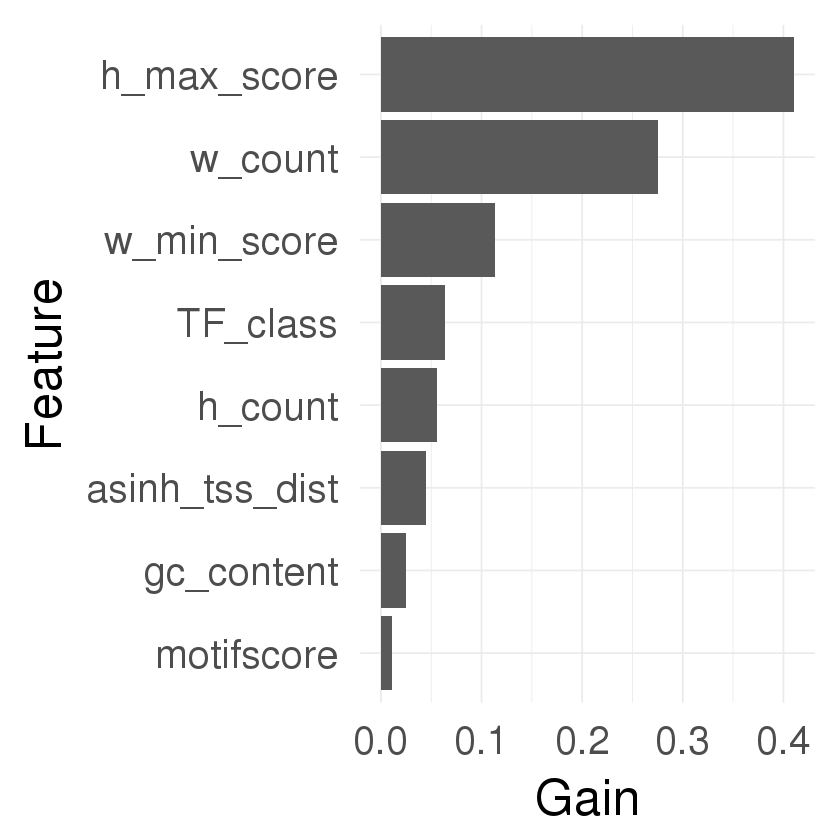

In [31]:
importance_matrix <- xgb.importance(colnames(X_train),model=gbdt_medium)

df <- as_data_frame(importance_matrix)
df.tf <- subset(df, Feature %in% unique(motif_class_pairs$class))
df.notf <- subset(df, !(Feature %in% unique(motif_class_pairs$class)))
tfclass.row <- c("TF_class", unname(as.list(colSums(df.tf[!(colnames(df.tf) %in% c("Feature"))]))) )
names(tfclass.row) <- colnames(df)
df.sum <- rbind(df.notf,tfclass.row)

ggplot(data=df.sum, aes(x=reorder(Feature, Gain), y=Gain)) +
    geom_bar(stat="identity") +
    coord_flip() +
    theme_minimal(base_size = 30) +
    labs(x = "Feature", y="Gain")

In [ ]:
medium_pred_df <- make.pred.df.from.model(gbdt_medium, X_test, y_test)
colnames(medium_pred_df)[1] <- "ChIPseq.bound"
medium_stat_df <- make.stats.df.from.preds(medium_pred_df)

## Train a linear model on all features

In [ ]:
X_train_lin <- X_train
y_train_lin <- y_train
X_test_lin  <- X_test
y_test_lin  <- y_test

In [ ]:
tf.regressors <- colnames(X_train_lin)[colnames(X_train_lin) %in% unique(motif_class_pairs$class)]
non.tf.regressors <-  colnames(X_train_lin)[!colnames(X_train_lin) %in% unique(motif_class_pairs$class)]

tf.regressors.formula <- paste("as.factor(", paste(tf.regressors, collapse=") + as.factor("), ")")
non.tf.regressors.formula <- paste(non.tf.regressors, collapse=" + ")
all.regressors.formula <- paste(non.tf.regressors.formula, tf.regressors.formula, sep=" + ")

glm.formula <- paste("ChIPseq.bound ~ ", all.regressors.formula, sep='')

glm.df.train <- as.data.frame(cbind("ChIPseq.bound"=y_train_lin, X_train_lin))
glm.df.test <-  as.data.frame(cbind("ChIPseq.bound"=y_test_lin, X_test_lin))

glm.all <- glm(as.formula(glm.formula), data=glm.df.train, family=binomial)
glm.all$Model.Name <- "glm small"

In [ ]:
glm.pred.df <- make.pred.df.from.glm(glm.all, glm.df.test)
glm.stat.df <- make.stats.df.from.preds(glm.pred.df)

## Linear Model on all Features Independently

In [ ]:
stats.regressors.df <- data.frame()

for (this.regressor in colnames(X_train_lin)) {
    
    if (this.regressor %in% unique(motif_class_pairs$class)) {
        glm.formula <- paste("ChIPseq.bound ~ ", "as.factor(", this.regressor, ")",sep='')
    } else {
        glm.formula <- paste("ChIPseq.bound ~ ", this.regressor,sep='')
    }

    glm.df.train <- as.data.frame(cbind("ChIPseq.bound"=y_train_lin, X_train_lin))
    glm.df.test <-  as.data.frame(cbind("ChIPseq.bound"=y_test_lin, X_test_lin))

    glm.single <- glm(as.formula(glm.formula), data=glm.df.train, family=binomial)
    glm.single$Model.Name <- paste("glm ", this.regressor, sep='')
    
    glm.pred.single.df <- make.pred.df.from.glm(glm.single, glm.df.test)
    glm.stat.single.df <- make.stats.df.from.preds(glm.pred.single.df)
    
    stats.regressors.df <- rbind(stats.regressors.df, glm.stat.single.df)
    
}

In [ ]:
stats.regressors.df %>% 
filter(Model.Name %in% c("glm motifscore",
                         "glm h_count",
                         "glm h_max_score",
                         "glm w_count",
                         "glm w_min_score",
                         "glm gc_content",
                         "glm asinh_tss_dist")) ->
stats.regressors.filtered.df

## compare performace

In [ ]:
all.stats.df <- rbind(
    medium_stat_df,
    glm.stat.df,
    stats.regressors.filtered.df
)

In [ ]:
plot.mattcc.curve(all.stats.df) + theme_minimal(base_size = 15)

In [ ]:
plot.roc.curve(all.stats.df) + theme_minimal(base_size = 15)

In [ ]:
plot.precrecall.curve(all.stats.df) + theme_minimal(base_size = 15)